https://journals.ametsoc.org/view/journals/atot/27/3/2009jtecho725_1.xml

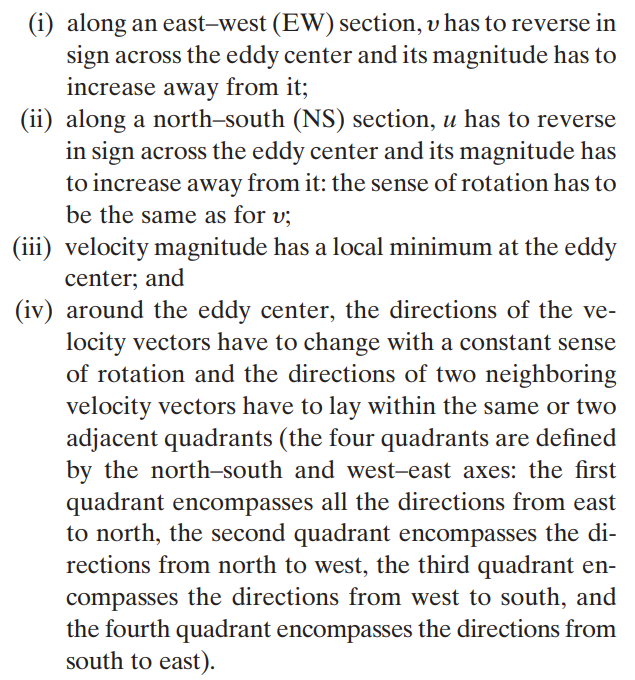

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib notebook
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
from scipy.io import netcdf_file
import os
# https://resources.marine.copernicus.eu/product-download/SEALEVEL_EUR_PHY_L4_MY_008_068
f = netcdf_file(os.path.join(os.path.abspath('') ,"data2.nc"))
lat = f.variables['latitude'].data
long = f.variables['longitude'].data
vel_u = f.variables['ugos'].data.squeeze()
vel_v = f.variables['vgos'].data.squeeze()


# fill in missing values
from common_functions import interpolate_missing_point

#imputed_vel_u = interpolate_missing_point(vel_u, np.ma.masked_invalid(vel_u).mask)
#imputed_vel_v = interpolate_missing_point(vel_v, np.ma.masked_invalid(vel_v).mask)
imputed_vel_u = np.nan_to_num(vel_u, nan=1e30)[60:82,10:40]
imputed_vel_v = np.nan_to_num(vel_v, nan=1e30)[60:82,10:40]
lat = lat[60:82]
long = long[10:40]

## Method Parameters:

In [3]:
a = 1
b = 1

## Constaint 3 

<IPython.core.display.Javascript object>


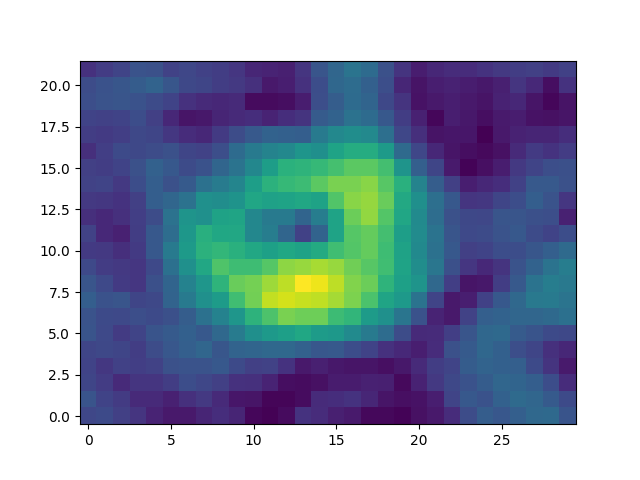

<IPython.core.display.Javascript object>


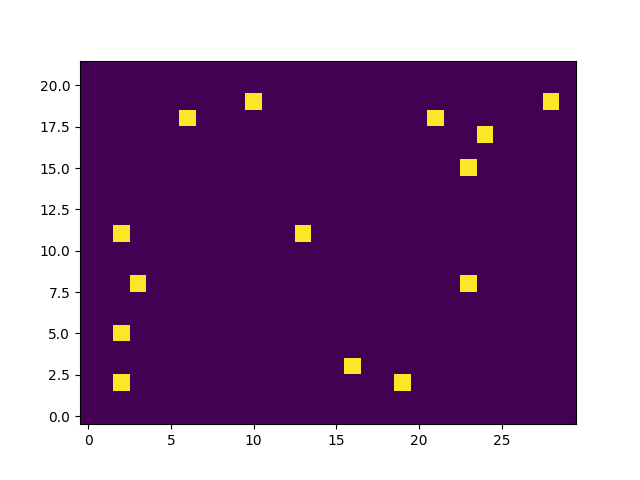

14


In [4]:
from skimage.feature import peak_local_max

vel_magnitude = np.hypot(imputed_vel_u, imputed_vel_v)
plt.figure()
plt.imshow(vel_magnitude, origin="lower")

satifies_crit_3 = peak_local_max(-vel_magnitude, min_distance=b)

plt.figure()
tmp = np.zeros_like(imputed_vel_u)
tmp[tuple(np.transpose(satifies_crit_3))] = 1
plt.imshow(tmp, origin="lower")
print(len(satifies_crit_3))

## Constraint 1

<IPython.core.display.Javascript object>


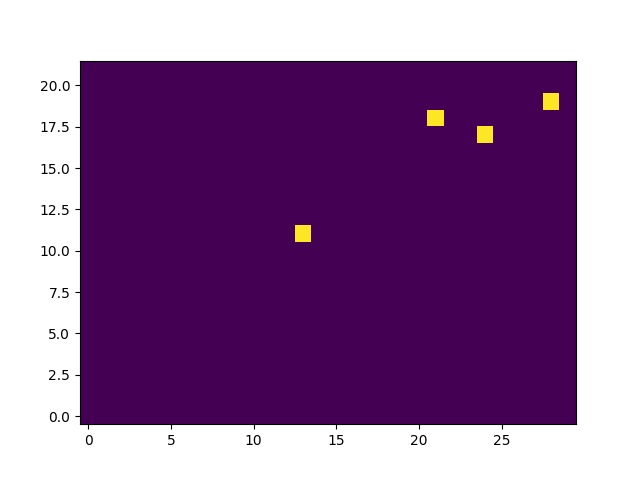

4


In [5]:
satifies_crit_1 = []
direction = []

for i,j in satifies_crit_3:
    center = imputed_vel_v[i,j]
    try:
        left = imputed_vel_v[i,j-a]
        right = imputed_vel_v[i,j+a]
    except IndexError:
        continue # point too close to the edge
    if abs(center) < abs(right) and abs(center) < abs(left) and np.sign(left)*np.sign(right) == -1:
        satifies_crit_1.append((i,j))
        direction.append(np.sign(left))

plt.figure()
tmp = np.zeros_like(imputed_vel_u)
tmp[tuple(np.transpose(satifies_crit_1))] = 1
plt.imshow(tmp, origin="lower")
print(len(satifies_crit_1))

## Constraint 2

i=17,j=24, center=0.0006000000000000001, bottom=0.0059, top=0.0098
i=19,j=28, center=-0.0058000000000000005, bottom=0.014700000000000001, top=0.011300000000000001
i=18,j=21, center=0.0068000000000000005, bottom=-0.0041, top=0.0179
i=11,j=13, center=0.0587, bottom=0.1758, top=-0.0975


<IPython.core.display.Javascript object>


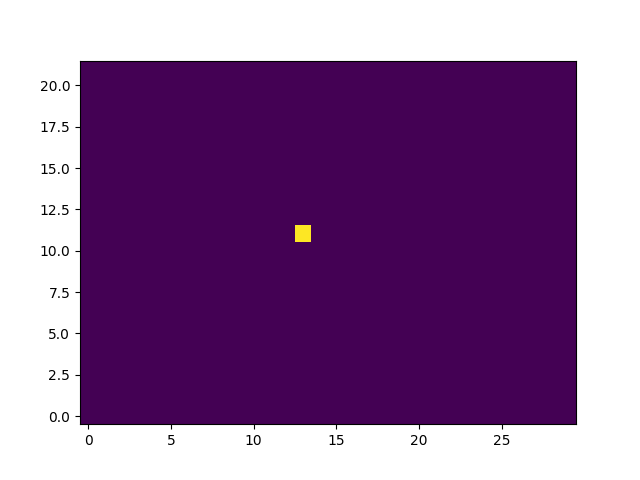

1


In [6]:
satifies_crit_2 = []

for (i, j), clockwise in zip(satifies_crit_1, direction):
    center = imputed_vel_u[i,j]
    try:
        bottom = imputed_vel_u[i-a, j]
        top = imputed_vel_u[i+a,j]
    except IndexError:
        continue # point to close to the edge
    print(f"{i=},{j=}, {center=}, {bottom=}, {top=}")
    if abs(center) < abs(bottom) and abs(center) < abs(top) and np.sign(bottom)*np.sign(top) == -1 and clockwise == np.sign(top):
        satifies_crit_2.append((i,j))

plt.figure()
tmp = np.zeros_like(imputed_vel_u)
tmp[tuple(np.transpose(satifies_crit_2))] = 1
plt.imshow(tmp, origin="lower")
print(len(satifies_crit_2))

## Constraint 4

## Plot the final thing

In [8]:
print(satifies_crit_2)

[(11, 13)]


<IPython.core.display.Javascript object>


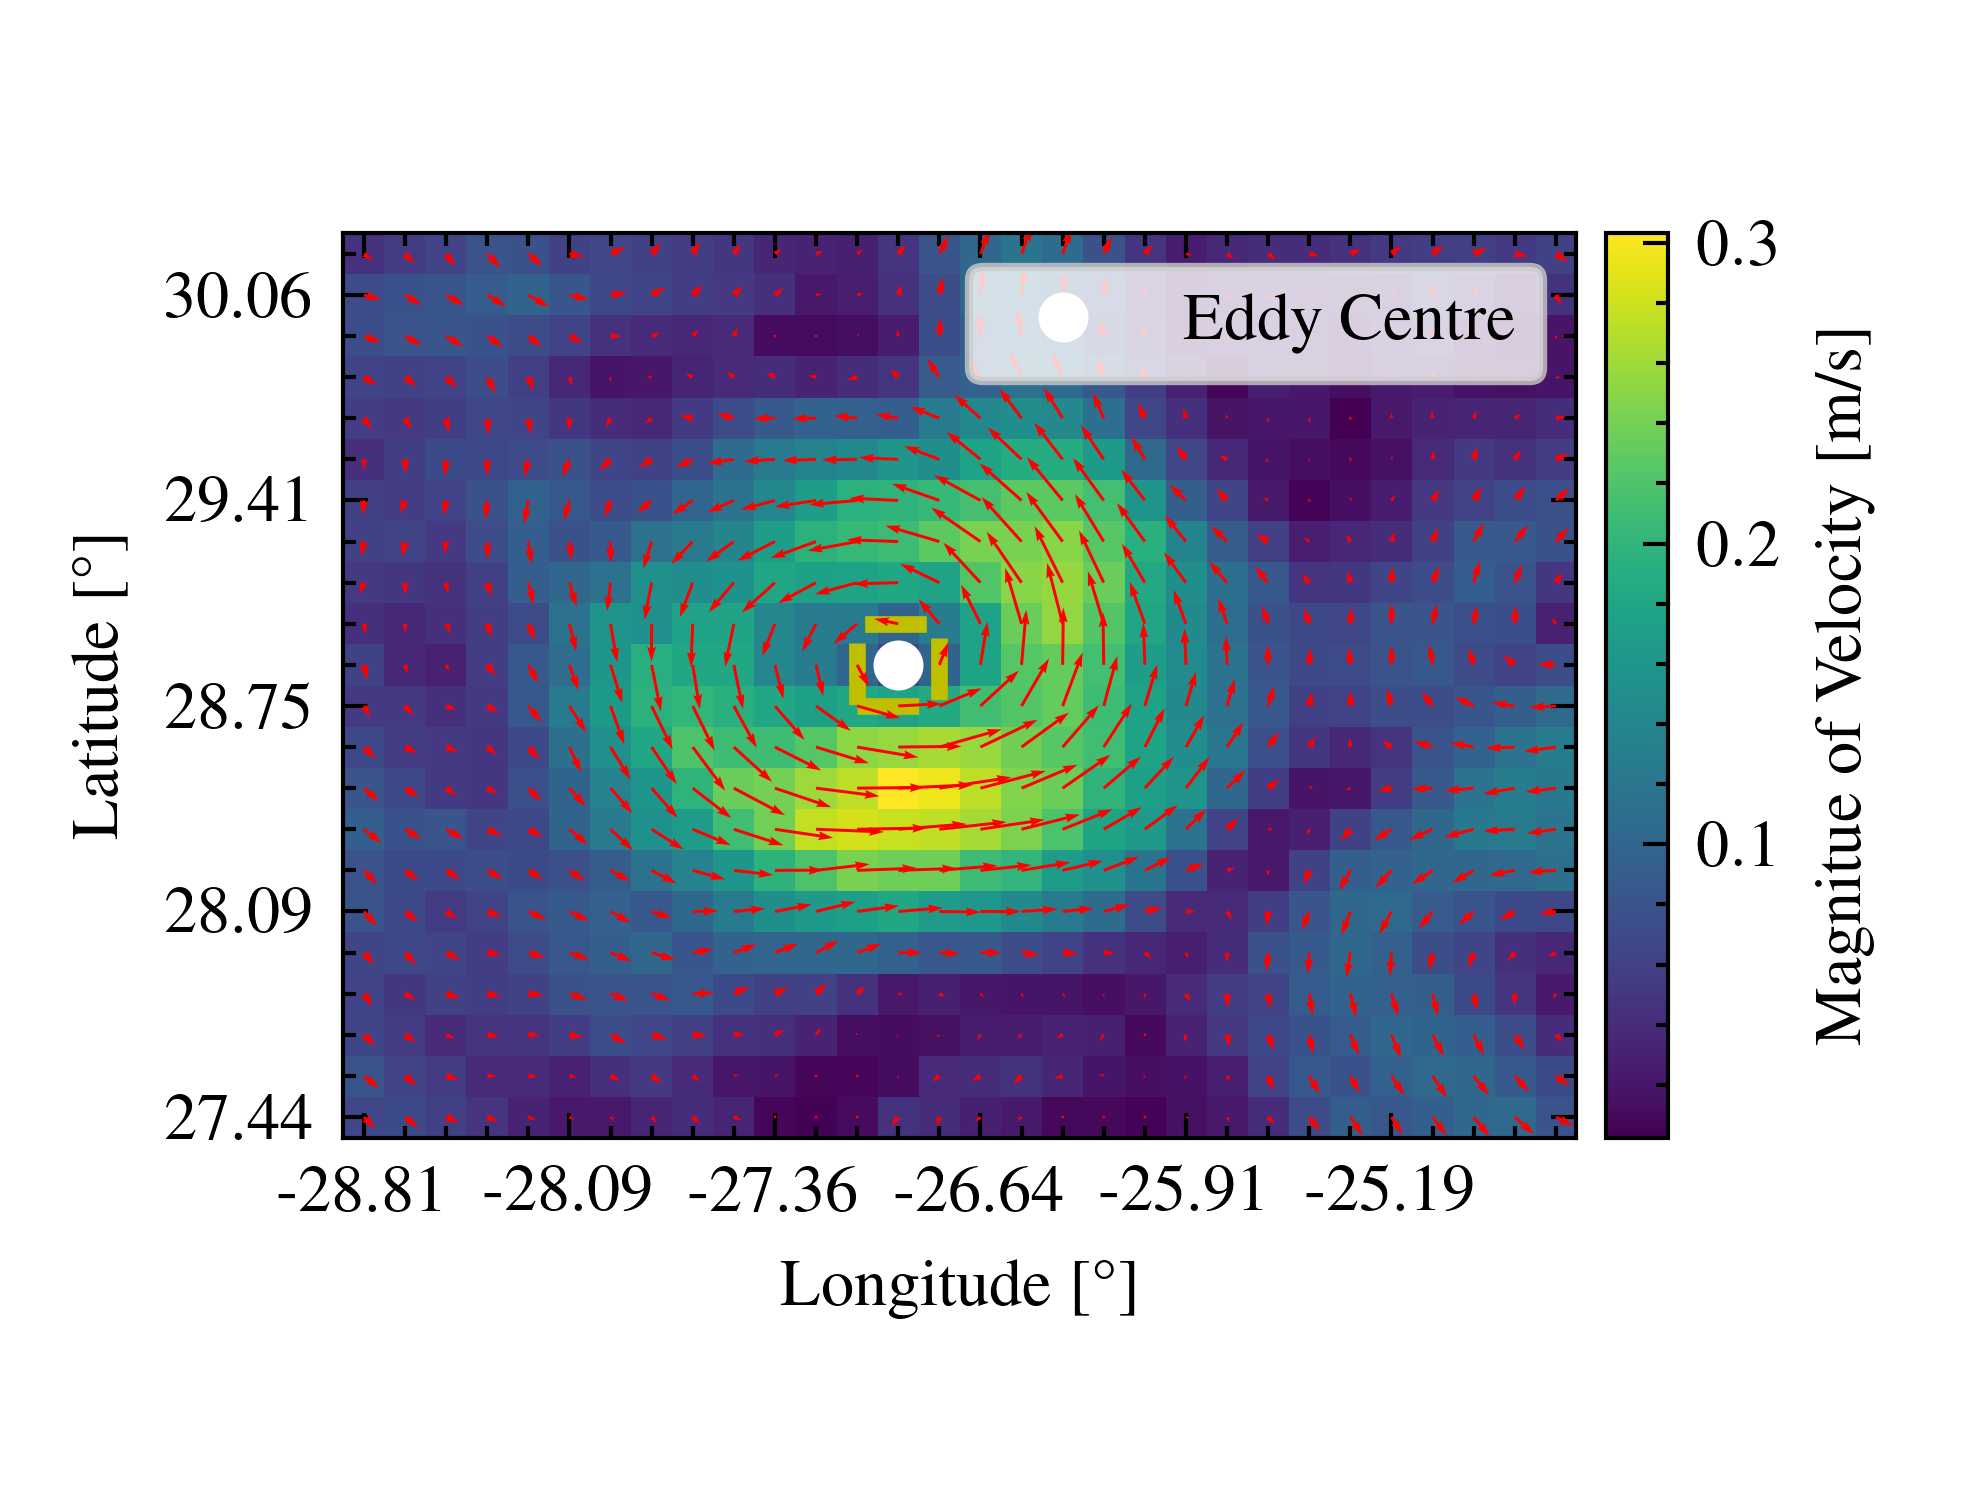

In [13]:
plt.style.use(['science','ieee'])

from matplotlib.patches import Rectangle

eddies = np.asarray(satifies_crit_2)

# start with magnitude of velocity as background
plt.figure()
im = plt.imshow(vel_magnitude, origin='lower')
plt.quiver(imputed_vel_u, imputed_vel_v, color='r', scale=5, zorder=2)
plt.plot(eddies[:,1], eddies[:,0],'w.', markersize=10, label="Eddy Centre")
plt.gca().add_patch(Rectangle(eddies[0,:] - (-1,3), 2, 2 , linewidth=2,edgecolor='y',facecolor='none', linestyle='--'))
plt.legend(loc='upper right', frameon=True)
plt.xlabel("Longitude [°]")
plt.ylabel("Latitude [°]")
current_xticks = plt.gca().get_xticks()[1:-1]
plt.xticks(current_xticks, np.around(np.linspace(long.min(),long.max(), len(current_xticks)), 2))
current_yticks = plt.gca().get_yticks()[1:-1]
plt.yticks(current_yticks, np.around(np.linspace(lat.min(),lat.max(), len(current_yticks)), 2))

ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
   
cbar = plt.colorbar(im, cax=cax)
cbar.set_label("Magnitue of Velocity [m/s]")

plt.tight_layout()
plt.savefig("figures/vectorgeom.pdf")